In [20]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

from utils import labeled_regression_plot

## Image compression via SVD

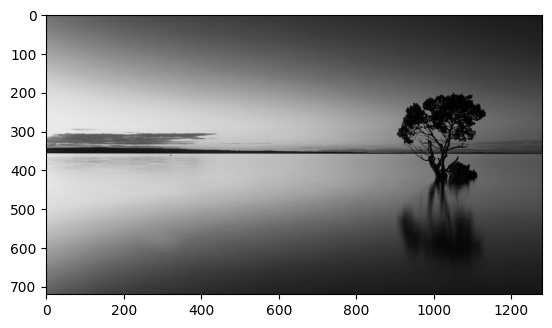

In [11]:
img = Image.open("data/sunset.jpg")

# Convert to grayscale so we don't have to deal with the complexity of multiple
# color channels
img = img.convert('LA')
plt.imshow(img)

# Covnert into numpy matrix
img_mat = np.array(list(img.getdata(band=0)), float)
img_mat.shape = (img.size[1], img.size[0])
img_mat = np.matrix(img_mat)

In [13]:
# Calculate SVD of image
U, sigma, V = torch.linalg.svd(torch.Tensor(img_mat))

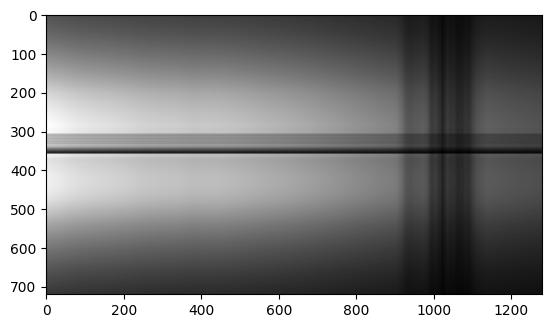

In [14]:
# As eigenvalues are arranged in descending order in diag(sigma) so to are singular
# values, by convention, arranged in descending order in D. Thus, the first
# left-singular vector of U and first right-singular vector of V may represent the
# most prominent feature of the image.
reconstructed_img = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstructed_img, cmap="gray")

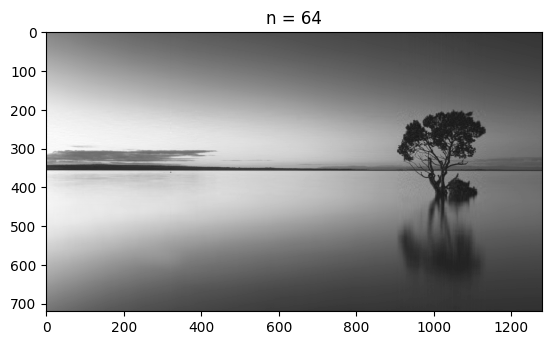

In [18]:
# Additional singular vectors improve the image quality
for i in [2, 4, 8, 16, 32, 64]:
    reconstructed = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstructed, cmap="gray")
    plt.title(f"n = {i}")

In [28]:
# With 64 singular vectors, the image is very well reconstructed, but the data
# footprint is much smaller than the original image
print(f"Original shape => {img_mat.shape}")

full_size_representation = np.prod(img_mat.shape)
print(f"Original full size => {full_size_representation}")

svd_64_rep_full_size = 64*img_mat.shape[0] + 64 + 64*img_mat.shape[1]
print(f"Reconstructed image full size (64 steps) => {svd_64_rep_full_size}")

print(f"Compression result => {round((svd_64_rep_full_size/full_size_representation) * 100, 2)}%")

Original shape => (720, 1280)
Original full size => 921600
Reconstructed image full size (64 steps) => 128064
Compression result => 13.9%


## Principal Component Analysis (PCA)

In [35]:
iris = datasets.load_iris()
print(iris.data.shape)
print(iris.get("feature_names"))

(150, 4)

(150, 2)


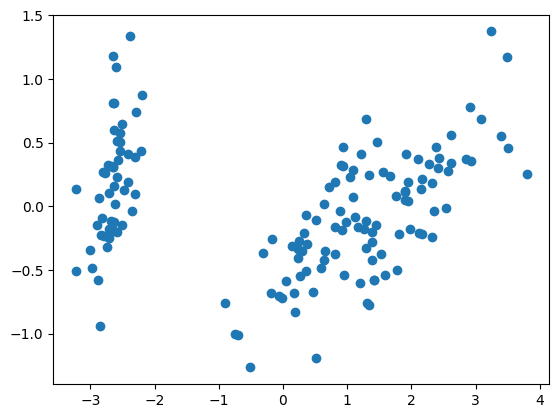

In [41]:
# two components to plot X,Y
pca = PCA(n_components=2)

X = pca.fit_transform(iris.data)
print(X.shape)

plt.scatter(X[:, 0], X[:, 1])

In [ ]:
# As we actually do have labels, we can classify the data
plt.scatter(X[:, 0], X[:, 1], c=iris.target)

## Gradient of a Single-Point Regression in depth
We're going to calculate the gradient of quadratic cost with respect of a straight-line regression model's parameter. 

We keep the partial derivatives as simple as possible by limiting the model to handling a single data point.

In [3]:
xs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.])
ys = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])

# Slope of a line y = mx + b
def regression(x, m, b):
    return m*x + b

# Random near-zero values
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

# This is just to keep derivatives as simple as possible, we just use a single
# instance i
i = 7
x = xs[i]
y = ys[i]


# Step 1: Forward pass - Pass inputs to the model to estimate the y-hat
# Predict a y
yhat = regression(x, m, b)

# Step 2: Compare y-hat with true y to calculate cost C
# We use just a quadratic cost as we have a single data point (SE instead of MSE)
def squared_error(yhat, y):
    return (yhat - y)**2

C = squared_error(yhat, y)

# Step 3.1: Calculate the gradient of cost w.r.t parameters, automatically
C.backward()

print("Calculated automatically =>")
print(f"Partial derivative of C with respect to m (dC/dm) is: {m.grad.item()}")
print(f"Partial derivative of C with respect to b (dC/db) is: {b.grad.item()}")

# Step 3.2: Calculate the gradient of cost w.r.t parameters, manually (no autograd)
#       C = (yhat - y)²
# C = u²                  u = yhat - y
#                         We are interested on calculate the partial derivative of du/dyhat
# dC/du = 2u = 2(yhat-y)  du/dyhat = 1 - 0 = 1
# We then join them by multiplication
# dC/dyhat = dC/du * du/dyhat = (2(yhat-y))(1) = 2(yhat-y)

# Then we need to differentiate yhat
#                   yhat = mx + b
# dy/db = 0 + 1 = 1              dy/dm = x
# Then we add them together to get the rest of the derivatives
# dC/dm = dC/dyhat * dyhat/dm = (2(yhat-y))x = 2x(yhat-y) <- partial derivative of C w.r.t. m
# dC/db = dC/dyhat * dyhat/db = (2(yhat-y))1 = 2(yhat-y) <- partial derivative of C w.r.t. b

print("Calculated manually => ")

m_derivative = 2*x*(yhat.item() - y)
b_derivative = 2*(yhat.item() - y)

print(f"Partial derivative of C with respect to m (dC/dm) is: {m_derivative}")
print(f"Partial derivative of C with respect to b (dC/dm) is: {b_derivative}")

Calculated automatically =>
Partial derivative of C with respect to m (dC/dm) is: 108.77999114990234
Partial derivative of C with respect to b (dC/db) is: 15.539999008178711
Calculated manually => 
Partial derivative of C with respect to m (dC/dm) is: 108.77999114990234
Partial derivative of C with respect to b (dC/dm) is: 15.539999008178711


#### The Gradient of Cost, ∇C
Pronunced "nabla C" is a vector of all the partial derivatives of C with respect to each of the individual model parameters

In [11]:
# In this case, we have only two parameters, b and m
# The gradient, as the formula saysm, is the transposed array of the partial derivatives
# w.r.t. of each parameter
gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
gradient

tensor([[ 15.5400],
        [108.7800]])

## Gradient of mean squared error calculated manually

We will calculate the gradient of mean squared error on a **batch** of data

In [9]:
xs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.])
ys = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])

# Slope of a line y = mx + b
def regression(x, m, b):
    return m*x + b

# Random near-zero values
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

# 1. Forward pass
yhats = regression(xs, m, b)
print(f"yhats => {yhats}")

# Step 2. Calculate cost C
def mse(yhat, y):
    sigma = torch.sum((yhat - y)**2)
    # Get average
    return sigma/len(y)

C = mse(yhats, ys)
print(f"cost => {C}")

# Step 3. Use autodiff to calculate gradient of C
C.backward()

print("Automatically calculated gradients => ")
print(f"Cost of MSE w.r.t model parameter 'm' => {m.grad}")
print(f"Cost of MSE w.r.t model parameter 'b' => {b.grad}")

# Now, we derive by hand the gradient of MSE

yhats => tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)
cost => 19.675472259521484
Automatically calculated gradients => 
Cost of MSE w.r.t model parameter 'm' => tensor([36.3050])
Cost of MSE w.r.t model parameter 'b' => tensor([6.2650])


$$
C = \frac{1}{n} \sum (\hat{y_i} - y_i)^2
$$

$$
C = \frac{1}{n} \sum u^2     \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  u = \hat{y}_i - y_i
$$


$$
\frac{\delta{C}}{\delta{u}} = \frac{1}{n}\sum{2u} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \frac{\delta{u}}{\delta{\hat{y_i}}} = 1 - 0 = 1
$$

$$
 = \frac{2}{n}\sum{u}           \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
$$

$$
 = \frac{2}{n}\sum{(\hat{y}_i - y_i)}           \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
$$

                        Taking into account all our equations => 

$$
\frac{\delta{C}}{\delta{u}} = \frac{2}{n}\sum{\hat{y}_i - y_i} \,\,\,\,\,\,\,\,\,\,
\frac{\delta{u}}{\delta{\hat{y}_i}} = 1 \,\,\,\,\,\,\,\,\,\, \frac{\delta{\hat{y}_i}}{\delta{m}} = x_i \,\,\,\,\,\,\,\,\,\, \frac{\delta{\hat{y}_i}}{\delta{b}} = 1
$$

                        We first derivate C with respect of b

$$
\frac{\delta{C}}{\delta{b}} = \frac{\delta{C}}{\delta{u}} \frac{\delta{u}}{\delta{\hat{y}_i}} \frac{\delta{\hat{y}_i}}{\delta{b}} = \frac{2}{n}\sum{\hat{y}_i - y_i} \cdot 1 \cdot 1 = \frac{2}{n}\sum{(\hat{y}_i - y_i)} 
$$

$$
\frac{\delta{C}}{\delta{m}} = \frac{\delta{C}}{\delta{u}} \frac{\delta{u}}{\delta{\hat{y}_i}} \frac{\delta{\hat{y}_i}}{\delta{m}} = \frac{2}{n}\sum{\hat{y}_i - y_i} \cdot 1 \cdot x_i = \frac{2}{n}\sum{(\hat{y}_i - y_i)} \cdot x_i
$$

In [ ]:
# Now, we interpret all of the above with code
print("Manually calculated => ")

$$
\frac{\delta{C}}{\delta{m}} = \frac{2}{n}\sum{(\hat{y}_i - y_i)} \cdot x_i
$$

In [12]:
m_manual = 2 * 1/len(ys) * torch.sum((yhats - ys) * xs)
print(f"Cost of MSE w.r.t model parameter 'm' => {m_manual}")

Cost of MSE w.r.t model parameter 'm' => 36.304996490478516


$$
\frac{\delta{C}}{\delta{b}} = = \frac{2}{n}\sum{(\hat{y}_i - y_i)} 
$$

In [14]:
b_manual = 2 * 1/len(ys) * torch.sum(yhats - ys)
print(f"Cost of MSE w.r.t model parameter 'b' => {b_manual}")

Cost of MSE w.r.t model parameter 'b' => 6.2649993896484375


This means that there's a stronger correlation (36.3) between reducing 'm' cost w.r.t. reducing C, and a weaker correlation  (6.26) between reducing 'b' cost w.r.t. reducing C.

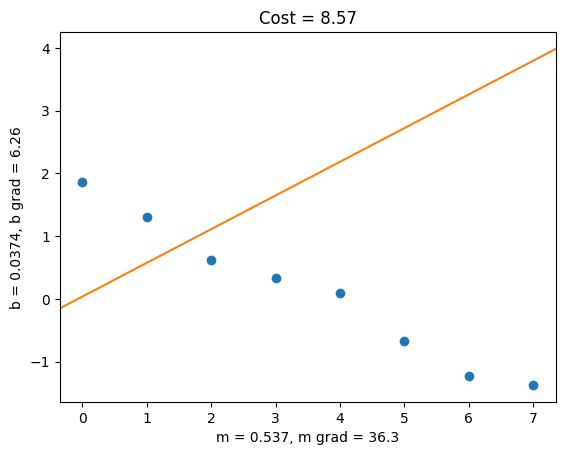

In [21]:
labeled_regression_plot(xs, ys, m, b, C)

In [15]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [16]:
optimizer.step()

In [17]:
C = mse(regression(xs, m, b), ys)

In [18]:
C

tensor(8.5722, grad_fn=<DivBackward0>)

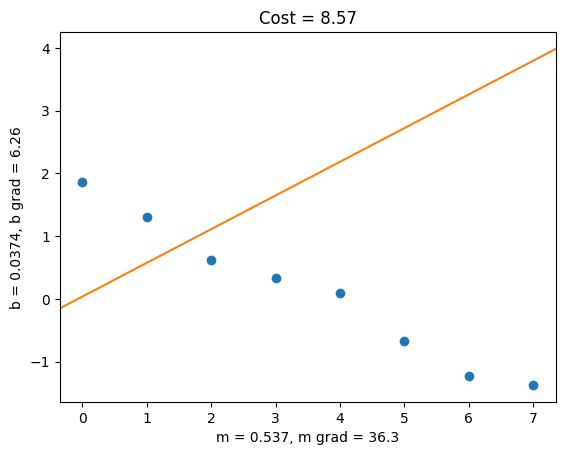

In [22]:
labeled_regression_plot(xs, ys, m, b, C)

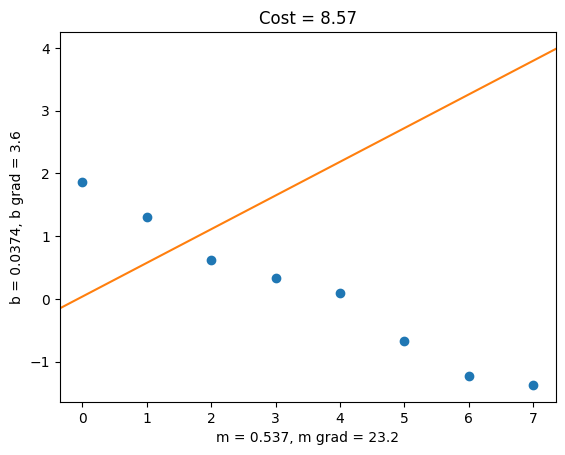

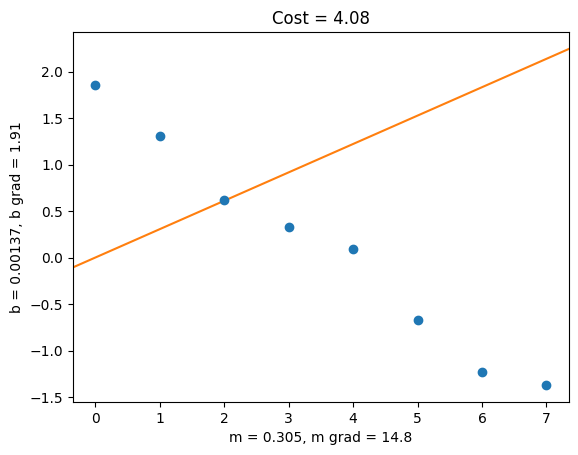

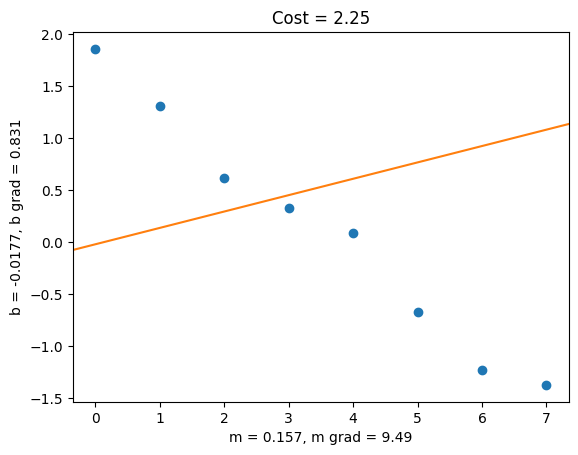

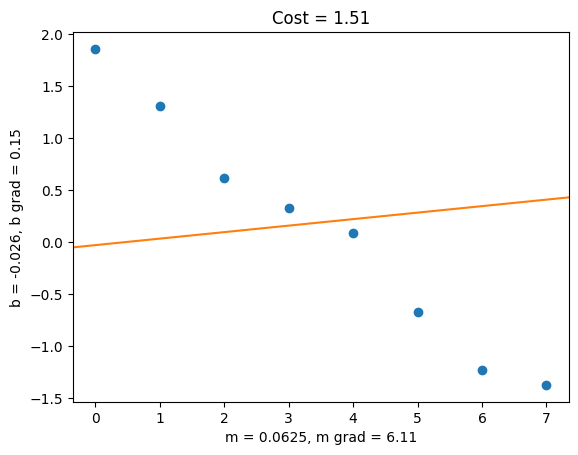

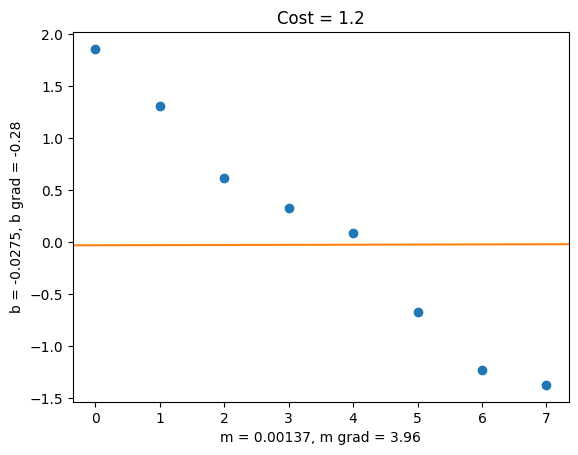

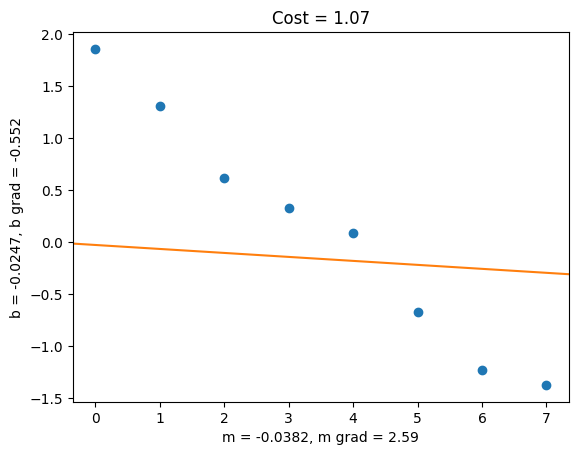

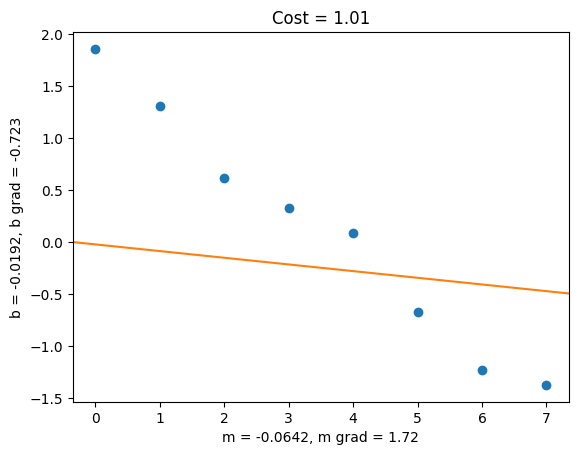

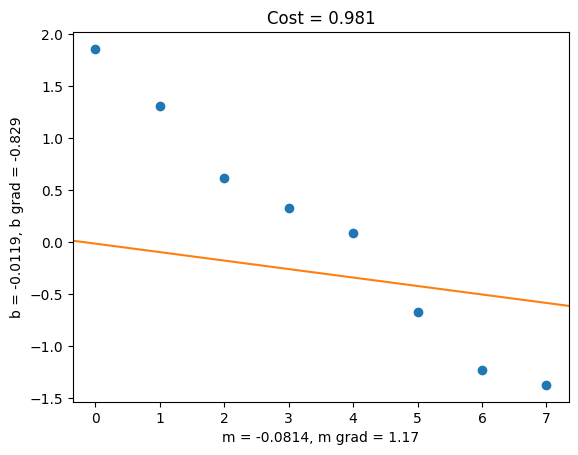

In [24]:
# Observe further rounds of training
epochs = 8
for epoch in range(epochs):
    optimizer.zero_grad()

    yhats = regression(xs, m, b)

    C = mse(yhats, ys)

    C.backward()

    # Notice how the cost is reduced after each epoch
    labeled_regression_plot(xs, ys, m, b, C)

    optimizer.step()